# Estimation of simulated VAR by ML using PyTorch

## Libraries

In [1]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import math

## Simulation of stationary time-series

In [2]:
# Time-series dimension of simulation

nsample = 1000
nvar = 4

In [3]:
# Create null data frames for storing data

df = torch.empty((nsample, nvar))
rho = torch.empty((nvar))

In [4]:
# Simulation of processes

# Start values

for i in range(0, df.shape[1]):
    df[0,i] = torch.rand(1)
    
# Rho parameters, smaller than one in absolute value
for i in range(0, df.shape[1]):
    rho[i] = torch.rand(1)

# Create the AR(1) processes
for i in range(1,df.shape[0]):
    for j in range(0, df.shape[1]):
        df[i,j] = rho[j]*df[i-1, j] + torch.randn(1)

print(df)

tensor([[ 0.1049,  0.8525,  0.1074,  0.7176],
        [ 1.5906,  0.6869,  0.7770, -0.0708],
        [ 1.9961,  0.0672, -0.3455,  1.1673],
        ...,
        [-0.5052,  0.3797, -0.7598, -0.6861],
        [-0.2659, -0.1756, -0.5292, -0.5989],
        [ 0.0224,  0.7816,  2.1030, -1.1926]])


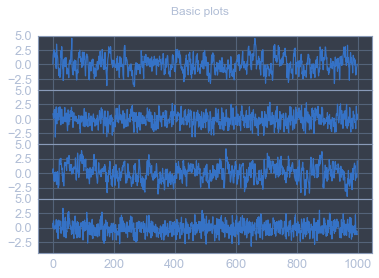

In [5]:
# Plots

f, axarr = plt.subplots(df.shape[1], sharex=True, sharey=True)
f.suptitle('Basic plots')

for i in range(0, df.shape[1]):
    axarr[i].plot(df[:,i].numpy())

# Bring subplots close to each other.
f.subplots_adjust(hspace=0)

# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.label_outer()

## VAR

In [6]:
class VAR:
    """ 
    **** VECTOR AUTOREGRESSION (VAR) MODELS ****
    ----------
    Parameters
    data : np.array
        Field to specify the time series data that will be used.
    lags : int
        Field to specify how many lag terms the model will have. 
    integ : int (default : 0)
        Specifies how many time to difference the dependent variables.
    target : str (pd.DataFrame) or int (np.array) (default : None)
        By default, all columns will be selected as the dependent variables.
    """

    def __init__(self,data,lags,target=None,integ=0):
        
        # Latent Variables
        self.lags = lags
        self.integ = integ
        self.target = target
        self.model_name = "VAR(" + str(self.lags) + ")"
        
        # Format the dependant variables
        self.data = data
        
        # Format the independent variables
        
        def diff(x, n):  
            """ Calculate the n-th order discrete difference
            """
            new_torch = torch.zeros(list(x.shape)[0]-n)
            if n == 0:
                new_torch = x
            else: 
                for i in range(list(x.shape)[0]-n):
                    new_torch[i] = x[i] - x[i+n]
            return new_torch

        # Difference data
        
        self.data = torch.t(torch.stack([diff(i, self.integ) for i in torch.t(self.data)]))
        self.T = self.data.shape[0]
        self.ylen = self.data.shape[1]
                                    
        """
        Y : torch.array
            Contains the length-adjusted time series (accounting for lags)
        """     

        self.Y = torch.t(self.data[self.lags:,])
        
    def _design(self):
        """ Creates a design matrix
        Z : np.array
        """ 
        
        Z = torch.ones(((self.ylen*self.lags+1), (self.T-self.lags)))

        row_count=1
        for lag in range(1, self.lags+1):
            for reg in range(self.ylen):
                Z[row_count, :] = self.data[:,reg][self.lags-lag:-lag]
                row_count += 1     
        return(Z)

    def OLS(self):
        """ Creates OLS coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix B
        """         
        
        Z = self._design()
        return torch.mm(torch.mm(self.Y,torch.t(Z)),torch.inverse(torch.mm(Z,torch.t(Z))))
    
    def MLE(self):
        """ Creates MLE coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix MLE
        ----------
        It is based on the assumption of normality of errors
        """     
        
        par = Variable(torch.ones(self.lags*(self.ylen**2) + self.ylen + self.ylen), requires_grad=True)
        
        coef = torch.reshape(par[0:self.lags*self.ylen**2], (self.ylen, self.lags*self.ylen))
        coef_mean = par[self.lags*self.ylen**2:self.lags*self.ylen**2+self.ylen]
        coef_var = torch.diag(par[self.lags*self.ylen**2+self.ylen:])    
        Z = self._design()[1:]

        Y_0 = torch.t(torch.t(self.Y) - coef_mean)
        Z_0 = torch.t(torch.t(Z) - coef_mean.repeat(self.lags))
        
        learning_rate = 1e-5
        
        optimizer = torch.optim.LBFGS(params = [par], lr=learning_rate, max_iter=25)
        
        def closure():
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the Tensors it will update (which are the learnable weights
            # of the model)
            optimizer.zero_grad()
            
            # First way (without a constant term in the likelihood function):
            loss = -(- .5*self.Y.shape[1]*torch.log(torch.abs(torch.det(coef_var))) - .5*torch.trace(torch.mm(torch.mm(torch.t(Y_0 - torch.mm(coef,Z_0)),torch.inverse(coef_var)),Y_0 - torch.mm(coef,Z_0))))

#              TO ADD: 
#             Second way:
#             dist = torch.distributions.MultivariateNormal(torch.mm(coef,Z_0), coef_var)
#             loss = -torch.mean(dist.log_prob(Y_0))
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward(retain_graph = True)
            
            print(loss)
            
            return loss
        
        # Calling the step function on an Optimizer makes an update to its parameters
        
        for i in range(50):
            optimizer.step(closure)
            
        return(par)

In [7]:
# Estimate VAR(p) by MLE

MLE_results = VAR(data = df, lags = 3, target = None, integ = 1).MLE()
MLE_results

tensor(265519.8125, grad_fn=<NegBackward>)
tensor(265519.7500, grad_fn=<NegBackward>)
tensor(265515.9375, grad_fn=<NegBackward>)
tensor(265512.4062, grad_fn=<NegBackward>)
tensor(265508.9062, grad_fn=<NegBackward>)
tensor(265505.3438, grad_fn=<NegBackward>)
tensor(265501.9375, grad_fn=<NegBackward>)
tensor(265498.5312, grad_fn=<NegBackward>)
tensor(265494.9688, grad_fn=<NegBackward>)
tensor(265491.4375, grad_fn=<NegBackward>)
tensor(265487.9688, grad_fn=<NegBackward>)
tensor(265484.2188, grad_fn=<NegBackward>)
tensor(265480.5938, grad_fn=<NegBackward>)
tensor(265476.8750, grad_fn=<NegBackward>)
tensor(265473.0938, grad_fn=<NegBackward>)
tensor(265469.2188, grad_fn=<NegBackward>)
tensor(265465.2500, grad_fn=<NegBackward>)
tensor(265461.2500, grad_fn=<NegBackward>)
tensor(265457.1562, grad_fn=<NegBackward>)
tensor(265452.9375, grad_fn=<NegBackward>)
tensor(265448.6250, grad_fn=<NegBackward>)
tensor(265444.2500, grad_fn=<NegBackward>)
tensor(265439.7188, grad_fn=<NegBackward>)
tensor(2654

tensor(247738.5000, grad_fn=<NegBackward>)
tensor(247603.6562, grad_fn=<NegBackward>)
tensor(247459.0938, grad_fn=<NegBackward>)
tensor(247324.1719, grad_fn=<NegBackward>)
tensor(247189.1250, grad_fn=<NegBackward>)
tensor(247045.8438, grad_fn=<NegBackward>)
tensor(246908.9844, grad_fn=<NegBackward>)
tensor(246764.0312, grad_fn=<NegBackward>)
tensor(246628.8906, grad_fn=<NegBackward>)
tensor(246480.6875, grad_fn=<NegBackward>)
tensor(246335.0312, grad_fn=<NegBackward>)
tensor(246189.3125, grad_fn=<NegBackward>)
tensor(246041.7188, grad_fn=<NegBackward>)
tensor(245890.3125, grad_fn=<NegBackward>)
tensor(245747.0625, grad_fn=<NegBackward>)
tensor(245590.7188, grad_fn=<NegBackward>)
tensor(245446.2344, grad_fn=<NegBackward>)
tensor(245286.2500, grad_fn=<NegBackward>)
tensor(245134.3125, grad_fn=<NegBackward>)
tensor(244972.4688, grad_fn=<NegBackward>)
tensor(244806.5781, grad_fn=<NegBackward>)
tensor(244649.9219, grad_fn=<NegBackward>)
tensor(244484.5312, grad_fn=<NegBackward>)
tensor(2443

tensor(215364.4062, grad_fn=<NegBackward>)
tensor(215217.7344, grad_fn=<NegBackward>)
tensor(215068.7188, grad_fn=<NegBackward>)
tensor(214925.9062, grad_fn=<NegBackward>)
tensor(214780.9219, grad_fn=<NegBackward>)
tensor(214630.0938, grad_fn=<NegBackward>)
tensor(214493.7344, grad_fn=<NegBackward>)
tensor(214347.4844, grad_fn=<NegBackward>)
tensor(214198.7656, grad_fn=<NegBackward>)
tensor(214061.1875, grad_fn=<NegBackward>)
tensor(213920.8750, grad_fn=<NegBackward>)
tensor(213780.8906, grad_fn=<NegBackward>)
tensor(213632.8594, grad_fn=<NegBackward>)
tensor(213498.2500, grad_fn=<NegBackward>)
tensor(213356.7344, grad_fn=<NegBackward>)
tensor(213217.2344, grad_fn=<NegBackward>)
tensor(213079.8125, grad_fn=<NegBackward>)
tensor(212941.6406, grad_fn=<NegBackward>)
tensor(212804.2969, grad_fn=<NegBackward>)
tensor(212670.6562, grad_fn=<NegBackward>)
tensor(212534.7344, grad_fn=<NegBackward>)
tensor(212402.2188, grad_fn=<NegBackward>)
tensor(212261.7656, grad_fn=<NegBackward>)
tensor(2121

tensor(188098.9688, grad_fn=<NegBackward>)
tensor(187966.8594, grad_fn=<NegBackward>)
tensor(187833.2500, grad_fn=<NegBackward>)
tensor(187707.0312, grad_fn=<NegBackward>)
tensor(187573.4062, grad_fn=<NegBackward>)
tensor(187443.0938, grad_fn=<NegBackward>)
tensor(187312.7656, grad_fn=<NegBackward>)
tensor(187186.0938, grad_fn=<NegBackward>)
tensor(187050.4219, grad_fn=<NegBackward>)
tensor(186920.1250, grad_fn=<NegBackward>)
tensor(186794.5625, grad_fn=<NegBackward>)
tensor(186659.6719, grad_fn=<NegBackward>)
tensor(186527.7656, grad_fn=<NegBackward>)
tensor(186397.4375, grad_fn=<NegBackward>)
tensor(186266.7969, grad_fn=<NegBackward>)
tensor(186135.1250, grad_fn=<NegBackward>)
tensor(186009.6719, grad_fn=<NegBackward>)
tensor(185873.8750, grad_fn=<NegBackward>)
tensor(185750.2031, grad_fn=<NegBackward>)
tensor(185613.5000, grad_fn=<NegBackward>)
tensor(185483.3594, grad_fn=<NegBackward>)
tensor(185358.8281, grad_fn=<NegBackward>)
tensor(185227., grad_fn=<NegBackward>)
tensor(185096.4

tensor(164641.4375, grad_fn=<NegBackward>)
tensor(164558.4062, grad_fn=<NegBackward>)
tensor(164473.4531, grad_fn=<NegBackward>)
tensor(164391.2812, grad_fn=<NegBackward>)
tensor(164313.0938, grad_fn=<NegBackward>)
tensor(164230., grad_fn=<NegBackward>)
tensor(164152.6719, grad_fn=<NegBackward>)
tensor(164072.5000, grad_fn=<NegBackward>)
tensor(163991.7344, grad_fn=<NegBackward>)
tensor(163914.4375, grad_fn=<NegBackward>)
tensor(163838.0781, grad_fn=<NegBackward>)
tensor(163761.1406, grad_fn=<NegBackward>)
tensor(163685.8438, grad_fn=<NegBackward>)
tensor(163605.5469, grad_fn=<NegBackward>)
tensor(163529.2344, grad_fn=<NegBackward>)
tensor(163453.0156, grad_fn=<NegBackward>)
tensor(163377.2969, grad_fn=<NegBackward>)
tensor(163300.8594, grad_fn=<NegBackward>)
tensor(163219.7500, grad_fn=<NegBackward>)
tensor(163144.7656, grad_fn=<NegBackward>)
tensor(163063.6094, grad_fn=<NegBackward>)
tensor(162984.2500, grad_fn=<NegBackward>)
tensor(162898.1094, grad_fn=<NegBackward>)
tensor(162814.0

tensor(144148.7500, grad_fn=<NegBackward>)
tensor(144054.1250, grad_fn=<NegBackward>)
tensor(143951.0781, grad_fn=<NegBackward>)
tensor(143859.2812, grad_fn=<NegBackward>)
tensor(143760.0781, grad_fn=<NegBackward>)
tensor(143665.2500, grad_fn=<NegBackward>)
tensor(143575.6562, grad_fn=<NegBackward>)
tensor(143483.2656, grad_fn=<NegBackward>)
tensor(143393.5469, grad_fn=<NegBackward>)
tensor(143301.8750, grad_fn=<NegBackward>)
tensor(143212.6406, grad_fn=<NegBackward>)
tensor(143122.9844, grad_fn=<NegBackward>)
tensor(143034.0469, grad_fn=<NegBackward>)
tensor(142950.1875, grad_fn=<NegBackward>)
tensor(142863.9375, grad_fn=<NegBackward>)
tensor(142778.4062, grad_fn=<NegBackward>)
tensor(142690.4844, grad_fn=<NegBackward>)
tensor(142607.1094, grad_fn=<NegBackward>)
tensor(142523.1875, grad_fn=<NegBackward>)
tensor(142444.2188, grad_fn=<NegBackward>)
tensor(142360.9375, grad_fn=<NegBackward>)
tensor(142279.7031, grad_fn=<NegBackward>)
tensor(142201.4688, grad_fn=<NegBackward>)
tensor(1421

tensor(115047.2031, grad_fn=<NegBackward>)
tensor(114836.7031, grad_fn=<NegBackward>)
tensor(114610.2109, grad_fn=<NegBackward>)
tensor(114410.4766, grad_fn=<NegBackward>)
tensor(114219.7969, grad_fn=<NegBackward>)
tensor(114036.0781, grad_fn=<NegBackward>)
tensor(113826.8516, grad_fn=<NegBackward>)
tensor(113614.3594, grad_fn=<NegBackward>)
tensor(113372.2266, grad_fn=<NegBackward>)
tensor(113189.6094, grad_fn=<NegBackward>)
tensor(112970.7812, grad_fn=<NegBackward>)
tensor(112742.7266, grad_fn=<NegBackward>)
tensor(112506.8594, grad_fn=<NegBackward>)
tensor(112245.5625, grad_fn=<NegBackward>)
tensor(112017.7891, grad_fn=<NegBackward>)
tensor(111779.9688, grad_fn=<NegBackward>)
tensor(111521.6406, grad_fn=<NegBackward>)
tensor(111245.8672, grad_fn=<NegBackward>)
tensor(110972.2656, grad_fn=<NegBackward>)
tensor(110720.0938, grad_fn=<NegBackward>)
tensor(110480.3750, grad_fn=<NegBackward>)
tensor(110134.7031, grad_fn=<NegBackward>)
tensor(109846.8672, grad_fn=<NegBackward>)
tensor(1095

tensor([0.5920, 0.6190, 0.6967, 0.6046, 0.5942, 0.6236, 0.7911, 0.7037, 0.6127,
        0.7704, 0.6893, 0.6110, 0.7523, 0.5510, 0.5826, 0.5958, 0.5948, 0.7351,
        0.5893, 0.7535, 0.8461, 0.6545, 0.6601, 0.5931, 0.6351, 0.7212, 0.5305,
        0.6357, 0.6397, 0.6657, 0.6312, 0.6596, 0.6441, 0.7986, 0.7123, 0.6307,
        0.7663, 0.6674, 0.6829, 0.6695, 0.6005, 0.6176, 0.7632, 0.6010, 0.6754,
        0.6639, 0.5885, 0.5864, 1.4334, 1.3129, 1.4955, 1.5486, 1.5449, 0.9956,
        1.1936, 1.7811], requires_grad=True)

In [8]:
# For more clarity, let's consider the specific case of VAR(1)

MLE_results = VAR(data = df, lags = 1, target = None, integ = 1).MLE();

tensor(33581.7031, grad_fn=<NegBackward>)
tensor(33581.6797, grad_fn=<NegBackward>)
tensor(33581.2148, grad_fn=<NegBackward>)
tensor(33580.7031, grad_fn=<NegBackward>)
tensor(33580.1758, grad_fn=<NegBackward>)
tensor(33579.6250, grad_fn=<NegBackward>)
tensor(33579.0352, grad_fn=<NegBackward>)
tensor(33578.4180, grad_fn=<NegBackward>)
tensor(33577.7383, grad_fn=<NegBackward>)
tensor(33577.0156, grad_fn=<NegBackward>)
tensor(33576.2539, grad_fn=<NegBackward>)
tensor(33575.4453, grad_fn=<NegBackward>)
tensor(33574.5234, grad_fn=<NegBackward>)
tensor(33573.5586, grad_fn=<NegBackward>)
tensor(33572.5312, grad_fn=<NegBackward>)
tensor(33571.4023, grad_fn=<NegBackward>)
tensor(33570.1602, grad_fn=<NegBackward>)
tensor(33568.7695, grad_fn=<NegBackward>)
tensor(33567.3086, grad_fn=<NegBackward>)
tensor(33565.6758, grad_fn=<NegBackward>)
tensor(33563.7773, grad_fn=<NegBackward>)
tensor(33561.8164, grad_fn=<NegBackward>)
tensor(33559.5938, grad_fn=<NegBackward>)
tensor(33557.0898, grad_fn=<NegBac

tensor(30120.5176, grad_fn=<NegBackward>)
tensor(30098.8496, grad_fn=<NegBackward>)
tensor(30078.0371, grad_fn=<NegBackward>)
tensor(30056.5117, grad_fn=<NegBackward>)
tensor(30035.6934, grad_fn=<NegBackward>)
tensor(30014.6992, grad_fn=<NegBackward>)
tensor(29993.7168, grad_fn=<NegBackward>)
tensor(29973.2969, grad_fn=<NegBackward>)
tensor(29953.6152, grad_fn=<NegBackward>)
tensor(29933.9785, grad_fn=<NegBackward>)
tensor(29914.0215, grad_fn=<NegBackward>)
tensor(29894.5371, grad_fn=<NegBackward>)
tensor(29874.9648, grad_fn=<NegBackward>)
tensor(29855.3496, grad_fn=<NegBackward>)
tensor(29834.4316, grad_fn=<NegBackward>)
tensor(29816.5703, grad_fn=<NegBackward>)
tensor(29798.2910, grad_fn=<NegBackward>)
tensor(29778.7070, grad_fn=<NegBackward>)
tensor(29760.1582, grad_fn=<NegBackward>)
tensor(29741.3750, grad_fn=<NegBackward>)
tensor(29723.3105, grad_fn=<NegBackward>)
tensor(29705.6523, grad_fn=<NegBackward>)
tensor(29686.9707, grad_fn=<NegBackward>)
tensor(29668.2734, grad_fn=<NegBac

tensor(26704.2305, grad_fn=<NegBackward>)
tensor(26689.4980, grad_fn=<NegBackward>)
tensor(26674.5859, grad_fn=<NegBackward>)
tensor(26658.9746, grad_fn=<NegBackward>)
tensor(26644.1094, grad_fn=<NegBackward>)
tensor(26628.5977, grad_fn=<NegBackward>)
tensor(26613.6934, grad_fn=<NegBackward>)
tensor(26597.9629, grad_fn=<NegBackward>)
tensor(26582.4512, grad_fn=<NegBackward>)
tensor(26566.5312, grad_fn=<NegBackward>)
tensor(26551.2715, grad_fn=<NegBackward>)
tensor(26534.9082, grad_fn=<NegBackward>)
tensor(26519.1738, grad_fn=<NegBackward>)
tensor(26504.2598, grad_fn=<NegBackward>)
tensor(26487., grad_fn=<NegBackward>)
tensor(26471.7734, grad_fn=<NegBackward>)
tensor(26454.4902, grad_fn=<NegBackward>)
tensor(26438.9824, grad_fn=<NegBackward>)
tensor(26422.7344, grad_fn=<NegBackward>)
tensor(26405.6445, grad_fn=<NegBackward>)
tensor(26389.5645, grad_fn=<NegBackward>)
tensor(26373.6738, grad_fn=<NegBackward>)
tensor(26357.0410, grad_fn=<NegBackward>)
tensor(26339.4746, grad_fn=<NegBackwar

tensor(23638.0117, grad_fn=<NegBackward>)
tensor(23624.8184, grad_fn=<NegBackward>)
tensor(23611.6738, grad_fn=<NegBackward>)
tensor(23598.4883, grad_fn=<NegBackward>)
tensor(23584.8574, grad_fn=<NegBackward>)
tensor(23571.9102, grad_fn=<NegBackward>)
tensor(23558.7812, grad_fn=<NegBackward>)
tensor(23545.7305, grad_fn=<NegBackward>)
tensor(23532.5820, grad_fn=<NegBackward>)
tensor(23519.9316, grad_fn=<NegBackward>)
tensor(23507.1426, grad_fn=<NegBackward>)
tensor(23494.0391, grad_fn=<NegBackward>)
tensor(23480.8438, grad_fn=<NegBackward>)
tensor(23468.8438, grad_fn=<NegBackward>)
tensor(23455.9434, grad_fn=<NegBackward>)
tensor(23443.0117, grad_fn=<NegBackward>)
tensor(23430.4941, grad_fn=<NegBackward>)
tensor(23418.1211, grad_fn=<NegBackward>)
tensor(23406.0938, grad_fn=<NegBackward>)
tensor(23393.3379, grad_fn=<NegBackward>)
tensor(23381.0234, grad_fn=<NegBackward>)
tensor(23369.2539, grad_fn=<NegBackward>)
tensor(23355.8809, grad_fn=<NegBackward>)
tensor(23344.1719, grad_fn=<NegBac

tensor(21179.6211, grad_fn=<NegBackward>)
tensor(21167.5703, grad_fn=<NegBackward>)
tensor(21156.7559, grad_fn=<NegBackward>)
tensor(21145.0371, grad_fn=<NegBackward>)
tensor(21133.5898, grad_fn=<NegBackward>)
tensor(21122.8828, grad_fn=<NegBackward>)
tensor(21112.0527, grad_fn=<NegBackward>)
tensor(21100.9062, grad_fn=<NegBackward>)
tensor(21089.6895, grad_fn=<NegBackward>)
tensor(21078.8418, grad_fn=<NegBackward>)
tensor(21068.2812, grad_fn=<NegBackward>)
tensor(21057.3340, grad_fn=<NegBackward>)
tensor(21046.6387, grad_fn=<NegBackward>)
tensor(21036.2051, grad_fn=<NegBackward>)
tensor(21025.7871, grad_fn=<NegBackward>)
tensor(21014.8750, grad_fn=<NegBackward>)
tensor(21004.4141, grad_fn=<NegBackward>)
tensor(20994.0449, grad_fn=<NegBackward>)
tensor(20983.4688, grad_fn=<NegBackward>)
tensor(20973.3770, grad_fn=<NegBackward>)
tensor(20962.6660, grad_fn=<NegBackward>)
tensor(20951.9082, grad_fn=<NegBackward>)
tensor(20941.8594, grad_fn=<NegBackward>)
tensor(20931.0059, grad_fn=<NegBac

tensor(19242.3613, grad_fn=<NegBackward>)
tensor(19235.3613, grad_fn=<NegBackward>)
tensor(19227.9141, grad_fn=<NegBackward>)
tensor(19220.5781, grad_fn=<NegBackward>)
tensor(19213.6211, grad_fn=<NegBackward>)
tensor(19205.8281, grad_fn=<NegBackward>)
tensor(19198.5000, grad_fn=<NegBackward>)
tensor(19191.4141, grad_fn=<NegBackward>)
tensor(19184.2207, grad_fn=<NegBackward>)
tensor(19176.6699, grad_fn=<NegBackward>)
tensor(19169.8262, grad_fn=<NegBackward>)
tensor(19162.0059, grad_fn=<NegBackward>)
tensor(19154.3105, grad_fn=<NegBackward>)
tensor(19147.1270, grad_fn=<NegBackward>)
tensor(19139.9180, grad_fn=<NegBackward>)
tensor(19132.3457, grad_fn=<NegBackward>)
tensor(19124.8887, grad_fn=<NegBackward>)
tensor(19117.4082, grad_fn=<NegBackward>)
tensor(19109.7969, grad_fn=<NegBackward>)
tensor(19102.1445, grad_fn=<NegBackward>)
tensor(19094.9609, grad_fn=<NegBackward>)
tensor(19087.0566, grad_fn=<NegBackward>)
tensor(19079.5020, grad_fn=<NegBackward>)
tensor(19071.9492, grad_fn=<NegBac

tensor(17524.9629, grad_fn=<NegBackward>)
tensor(17517.0332, grad_fn=<NegBackward>)
tensor(17508.4316, grad_fn=<NegBackward>)
tensor(17500.5137, grad_fn=<NegBackward>)
tensor(17492.4336, grad_fn=<NegBackward>)
tensor(17484.6445, grad_fn=<NegBackward>)
tensor(17476.8730, grad_fn=<NegBackward>)
tensor(17468.1309, grad_fn=<NegBackward>)
tensor(17460.1680, grad_fn=<NegBackward>)
tensor(17451.4102, grad_fn=<NegBackward>)
tensor(17443.9492, grad_fn=<NegBackward>)
tensor(17435.3906, grad_fn=<NegBackward>)
tensor(17426.9121, grad_fn=<NegBackward>)
tensor(17418.9219, grad_fn=<NegBackward>)


In [9]:
# Better visualisation of the results from previous cell

par_names_MLE = ['A AR(1)','B to A AR(1)','C to A AR(1)','D to A AR(1)',
                 'B AR(1)','A to B AR(1)','C to B AR(1)','D to B AR(1)',
                 'C AR(1)','A to C AR(1)','B to C AR(1)', 'D to C AR(1)',
                 'D AR(1)','A to D AR(1)','B to D AR(1)', 'C to D AR(1)',
                 'A Constant','B Constant', 'C Constant', 'D Constant',
                 'Var(A)','Var(B)','Var(C)','Var(D)'] 

results_MLE = dict(zip(par_names_MLE, MLE_results.flatten()))
results_MLE

{'A AR(1)': tensor(0.7347, grad_fn=<SelectBackward>),
 'B to A AR(1)': tensor(0.7605, grad_fn=<SelectBackward>),
 'C to A AR(1)': tensor(0.7499, grad_fn=<SelectBackward>),
 'D to A AR(1)': tensor(0.7130, grad_fn=<SelectBackward>),
 'B AR(1)': tensor(0.7569, grad_fn=<SelectBackward>),
 'A to B AR(1)': tensor(0.6857, grad_fn=<SelectBackward>),
 'C to B AR(1)': tensor(0.7630, grad_fn=<SelectBackward>),
 'D to B AR(1)': tensor(0.7278, grad_fn=<SelectBackward>),
 'C AR(1)': tensor(0.7577, grad_fn=<SelectBackward>),
 'A to C AR(1)': tensor(0.7333, grad_fn=<SelectBackward>),
 'B to C AR(1)': tensor(0.7268, grad_fn=<SelectBackward>),
 'D to C AR(1)': tensor(0.7299, grad_fn=<SelectBackward>),
 'D AR(1)': tensor(0.7755, grad_fn=<SelectBackward>),
 'A to D AR(1)': tensor(0.7310, grad_fn=<SelectBackward>),
 'B to D AR(1)': tensor(0.7779, grad_fn=<SelectBackward>),
 'C to D AR(1)': tensor(0.6399, grad_fn=<SelectBackward>),
 'A Constant': tensor(1.2780, grad_fn=<SelectBackward>),
 'B Constant': tens

In [10]:
# Estimate VAR(p) by OLS

OLS_results = VAR(data = df, lags = 3, target = None, integ = 3).OLS()
print(OLS_results)

tensor([[ 0.0056,  0.5796,  0.0711, -0.0110, -0.0431, -0.0343, -0.0334,  0.0540,
          0.0333, -0.3022,  0.0306, -0.0438,  0.0254],
        [ 0.0028, -0.0059,  0.2291,  0.0272,  0.0026,  0.0199, -0.0190,  0.0234,
         -0.0042,  0.0072, -0.5165,  0.0088, -0.0389],
        [-0.0008, -0.0189,  0.0048,  0.5118,  0.0326, -0.0049,  0.0132,  0.0422,
         -0.0110,  0.0034, -0.0163, -0.3944, -0.0566],
        [ 0.0044,  0.0113, -0.0340,  0.0800,  0.0758,  0.0050,  0.0442, -0.0193,
          0.0077, -0.0646,  0.0200, -0.0024, -0.4931]])


In [11]:
# For more clarity, let's consider the specific case of VAR(1)

OLS_results = VAR(data = df, lags = 1, target = None, integ = 1).OLS()

par_names_OLS = ['A Constant','A AR(1)','B to A AR(1)','C to A AR(1)','D to A AR(1)',
                 'B Constant','B AR(1)','A to B AR(1)','C to B AR(1)','D to B AR(1)',
                 'C Constant','C AR(1)','A to C AR(1)','B to C AR(1)', 'D to C AR(1)',
                 'D Constant','D AR(1)','A to D AR(1)','B to D AR(1)', 'C to D AR(1)'] 

results_OLS =  dict(zip(par_names_OLS, OLS_results.flatten()))
results_OLS

{'A Constant': tensor(0.0016),
 'A AR(1)': tensor(-0.1469),
 'B to A AR(1)': tensor(0.0509),
 'C to A AR(1)': tensor(0.0040),
 'D to A AR(1)': tensor(-0.0290),
 'B Constant': tensor(0.0002),
 'B AR(1)': tensor(-0.0317),
 'A to B AR(1)': tensor(-0.3053),
 'C to B AR(1)': tensor(0.0210),
 'D to B AR(1)': tensor(-0.0059),
 'C Constant': tensor(-0.0012),
 'C AR(1)': tensor(-0.0300),
 'A to C AR(1)': tensor(-0.0117),
 'B to C AR(1)': tensor(-0.1977),
 'D to C AR(1)': tensor(0.0264),
 'D Constant': tensor(0.0017),
 'D AR(1)': tensor(0.0251),
 'A to D AR(1)': tensor(-0.0442),
 'B to D AR(1)': tensor(0.0495),
 'C to D AR(1)': tensor(-0.4378)}